# 16. Differential gene expression analysis

In [28]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
%%R
library(edgeR)
library(MAST)

# 16.3. Preparing the dataset

In [4]:
adata = sc.read("/Users/adrian/General_projects/workflows-scrna/0_outs/kang.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

In [6]:
adata.obs[:5]

,nCount_RNA,nFeature_RNA,tsne1,tsne2,label,cluster,cell_type,replicate,nCount_SCT,nFeature_SCT,integrated_snn_res.0.4,seurat_clusters
index,,,,,,,,,,,,
AAACATACATTTCC-1,3017.0,877,-27.640373,14.966629,ctrl,9,CD14+ Monocytes,patient_1016,1704.0,711,1,1
AAACATACCAGAAA-1,2481.0,713,-27.493646,28.924885,ctrl,9,CD14+ Monocytes,patient_1256,1614.0,662,1,1
AAACATACCATGCA-1,703.0,337,-10.468194,-5.984389,ctrl,3,CD4 T cells,patient_1488,908.0,337,6,6
AAACATACCTCGCT-1,3420.0,850,-24.367997,20.429285,ctrl,9,CD14+ Monocytes,patient_1256,1738.0,653,1,1
AAACATACCTGGTA-1,3158.0,1111,27.952170,24.159738,ctrl,4,Dendritic cells,patient_1039,1857.0,928,12,12


In [7]:
np.max(adata.X)

3828.0

In [8]:
adata.layers["counts"] = adata.X.copy()

In [9]:
print(len(adata[adata.obs["label"] == "ctrl"].obs["replicate"].cat.categories))
print(len(adata[adata.obs["label"] == "stim"].obs["replicate"].cat.categories))

8
8


In [10]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 24562 × 15701
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_genes'
    var: 'name', 'n_cells'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

# 16.4. Pseudobulk

In [11]:
adata.obs["sample"] = [
    f"{rep}_{l}" for rep, l in zip(adata.obs["replicate"], adata.obs["label"])
]

In [12]:
adata.obs["cell_type"] = [ct.replace(" ", "_") for ct in adata.obs["cell_type"]]
adata.obs["cell_type"] = [ct.replace("+", "") for ct in adata.obs["cell_type"]]

In [13]:
adata.obs["replicate"] = adata.obs["replicate"].astype("category")
adata.obs["label"] = adata.obs["label"].astype("category")
adata.obs["sample"] = adata.obs["sample"].astype("category")
adata.obs["cell_type"] = adata.obs["cell_type"].astype("category")

In [14]:
NUM_OF_CELL_PER_DONOR = 30


def aggregate_and_filter(
    adata,
    cell_identity,
    donor_key="sample",
    condition_key="label",
    cell_identity_key="cell_type",
    obs_to_keep=[],  # which additional metadata to keep, e.g. gender, age, etc.
    replicates_per_patient=1,
):
    # subset adata to the given cell identity
    adata_cell_pop = adata[adata.obs[cell_identity_key] == cell_identity].copy()
    # check which donors to keep according to the number of cells specified with NUM_OF_CELL_PER_DONOR
    size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
    donors_to_drop = [
        donor
        for donor in size_by_donor.index
        if size_by_donor[donor] <= NUM_OF_CELL_PER_DONOR
    ]
    if len(donors_to_drop) > 0:
        print("Dropping the following samples:")
        print(donors_to_drop)
    df = pd.DataFrame(columns=[*adata_cell_pop.var_names, *obs_to_keep])

    adata_cell_pop.obs[donor_key] = adata_cell_pop.obs[donor_key].astype("category")
    for i, donor in enumerate(donors := adata_cell_pop.obs[donor_key].cat.categories):
        print(f"\tProcessing donor {i+1} out of {len(donors)}...", end="\r")
        if donor not in donors_to_drop:
            adata_donor = adata_cell_pop[adata_cell_pop.obs[donor_key] == donor]
            # create replicates for each donor
            indices = list(adata_donor.obs_names)
            random.shuffle(indices)
            indices = np.array_split(np.array(indices), replicates_per_patient)
            for i, rep_idx in enumerate(indices):
                adata_replicate = adata_donor[rep_idx]
                # specify how to aggregate: sum gene expression for each gene for each donor and also keep the condition information
                agg_dict = {gene: "sum" for gene in adata_replicate.var_names}
                for obs in obs_to_keep:
                    agg_dict[obs] = "first"
                # create a df with all genes, donor and condition info
                df_donor = pd.DataFrame(adata_replicate.X.A)
                df_donor.index = adata_replicate.obs_names
                df_donor.columns = adata_replicate.var_names
                df_donor = df_donor.join(adata_replicate.obs[obs_to_keep])
                # aggregate
                df_donor = df_donor.groupby(donor_key).agg(agg_dict)
                df_donor[donor_key] = donor
                df.loc[f"donor_{donor}_{i}"] = df_donor.loc[donor]
    print("\n")
    # create AnnData object from the df
    adata_cell_pop = sc.AnnData(
        df[adata_cell_pop.var_names], obs=df.drop(columns=adata_cell_pop.var_names)
    )
    return adata_cell_pop

In [15]:
%%R
fit_model <- function(adata_){
    # create an edgeR object with counts and grouping factor
    y <- DGEList(assay(adata_, "X"), group = colData(adata_)$label)
    # filter out genes with low counts
    print("Dimensions before subsetting:")
    print(dim(y))
    print("")
    keep <- filterByExpr(y)
    y <- y[keep, , keep.lib.sizes=FALSE]
    print("Dimensions after subsetting:")
    print(dim(y))
    print("")
    # normalize
    y <- calcNormFactors(y)
    # create a vector that is concatentation of condition and cell type that we will later use with contrasts
    group <- paste0(colData(adata_)$label, ".", colData(adata_)$cell_type)
    replicate <- colData(adata_)$replicate
    # create a design matrix: here we have multiple donors so also consider that in the design matrix
    design <- model.matrix(~ 0 + group + replicate)
    # estimate dispersion
    y <- estimateDisp(y, design = design)
    # fit the model
    fit <- glmQLFit(y, design)
    return(list("fit"=fit, "design"=design, "y"=y))
}

In [16]:
obs_to_keep = ["label", "cell_type", "replicate", "sample"]

In [17]:
adata.X = adata.layers["counts"].copy()

In [18]:
# process first cell type separately...
cell_type = adata.obs["cell_type"].cat.categories[0]
print(
    f'Processing {cell_type} (1 out of {len(adata.obs["cell_type"].cat.categories)})...'
)
adata_pb = aggregate_and_filter(adata, cell_type, obs_to_keep=obs_to_keep)
for i, cell_type in enumerate(adata.obs["cell_type"].cat.categories[1:]):
    print(
        f'Processing {cell_type} ({i+2} out of {len(adata.obs["cell_type"].cat.categories)})...'
    )
    adata_cell_type = aggregate_and_filter(adata, cell_type, obs_to_keep=obs_to_keep)
    adata_pb = adata_pb.concatenate(adata_cell_type)

Processing B_cells (1 out of 8)...
Dropping the following samples:
['patient_1039_ctrl']
	Processing donor 16 out of 16...

Processing CD14_Monocytes (2 out of 8)...
	Processing donor 16 out of 16...

Processing CD4_T_cells (3 out of 8)...
	Processing donor 16 out of 16...

Processing CD8_T_cells (4 out of 8)...
Dropping the following samples:
['patient_101_ctrl', 'patient_1039_ctrl', 'patient_1039_stim', 'patient_107_ctrl', 'patient_107_stim', 'patient_1244_ctrl', 'patient_1244_stim']
	Processing donor 16 out of 16...

Processing Dendritic_cells (5 out of 8)...
Dropping the following samples:
['patient_1016_ctrl', 'patient_1016_stim', 'patient_101_ctrl', 'patient_1039_ctrl', 'patient_1039_stim', 'patient_107_ctrl', 'patient_107_stim']
	Processing donor 16 out of 16...

Processing FCGR3A_Monocytes (6 out of 8)...
Dropping the following samples:
['patient_1039_ctrl', 'patient_1039_stim', 'patient_107_ctrl', 'patient_107_stim', 'patient_1244_stim']
	Processing donor 16 out of 16...

Proc

In [19]:
adata_pb.layers['counts'] = adata_pb.X.copy()

In [20]:
sc.pp.normalize_total(adata_pb, target_sum=1e6)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

In [22]:
adata_pb.obs["lib_size"] = np.sum(adata_pb.layers["counts"], axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"])

TypeError: loop of ufunc does not support argument 0 of type numpy.float32 which has no callable log method

In [63]:
np.log(adata_pb.obs["lib_size"])

TypeError: loop of ufunc does not support argument 0 of type numpy.float32 which has no callable log method

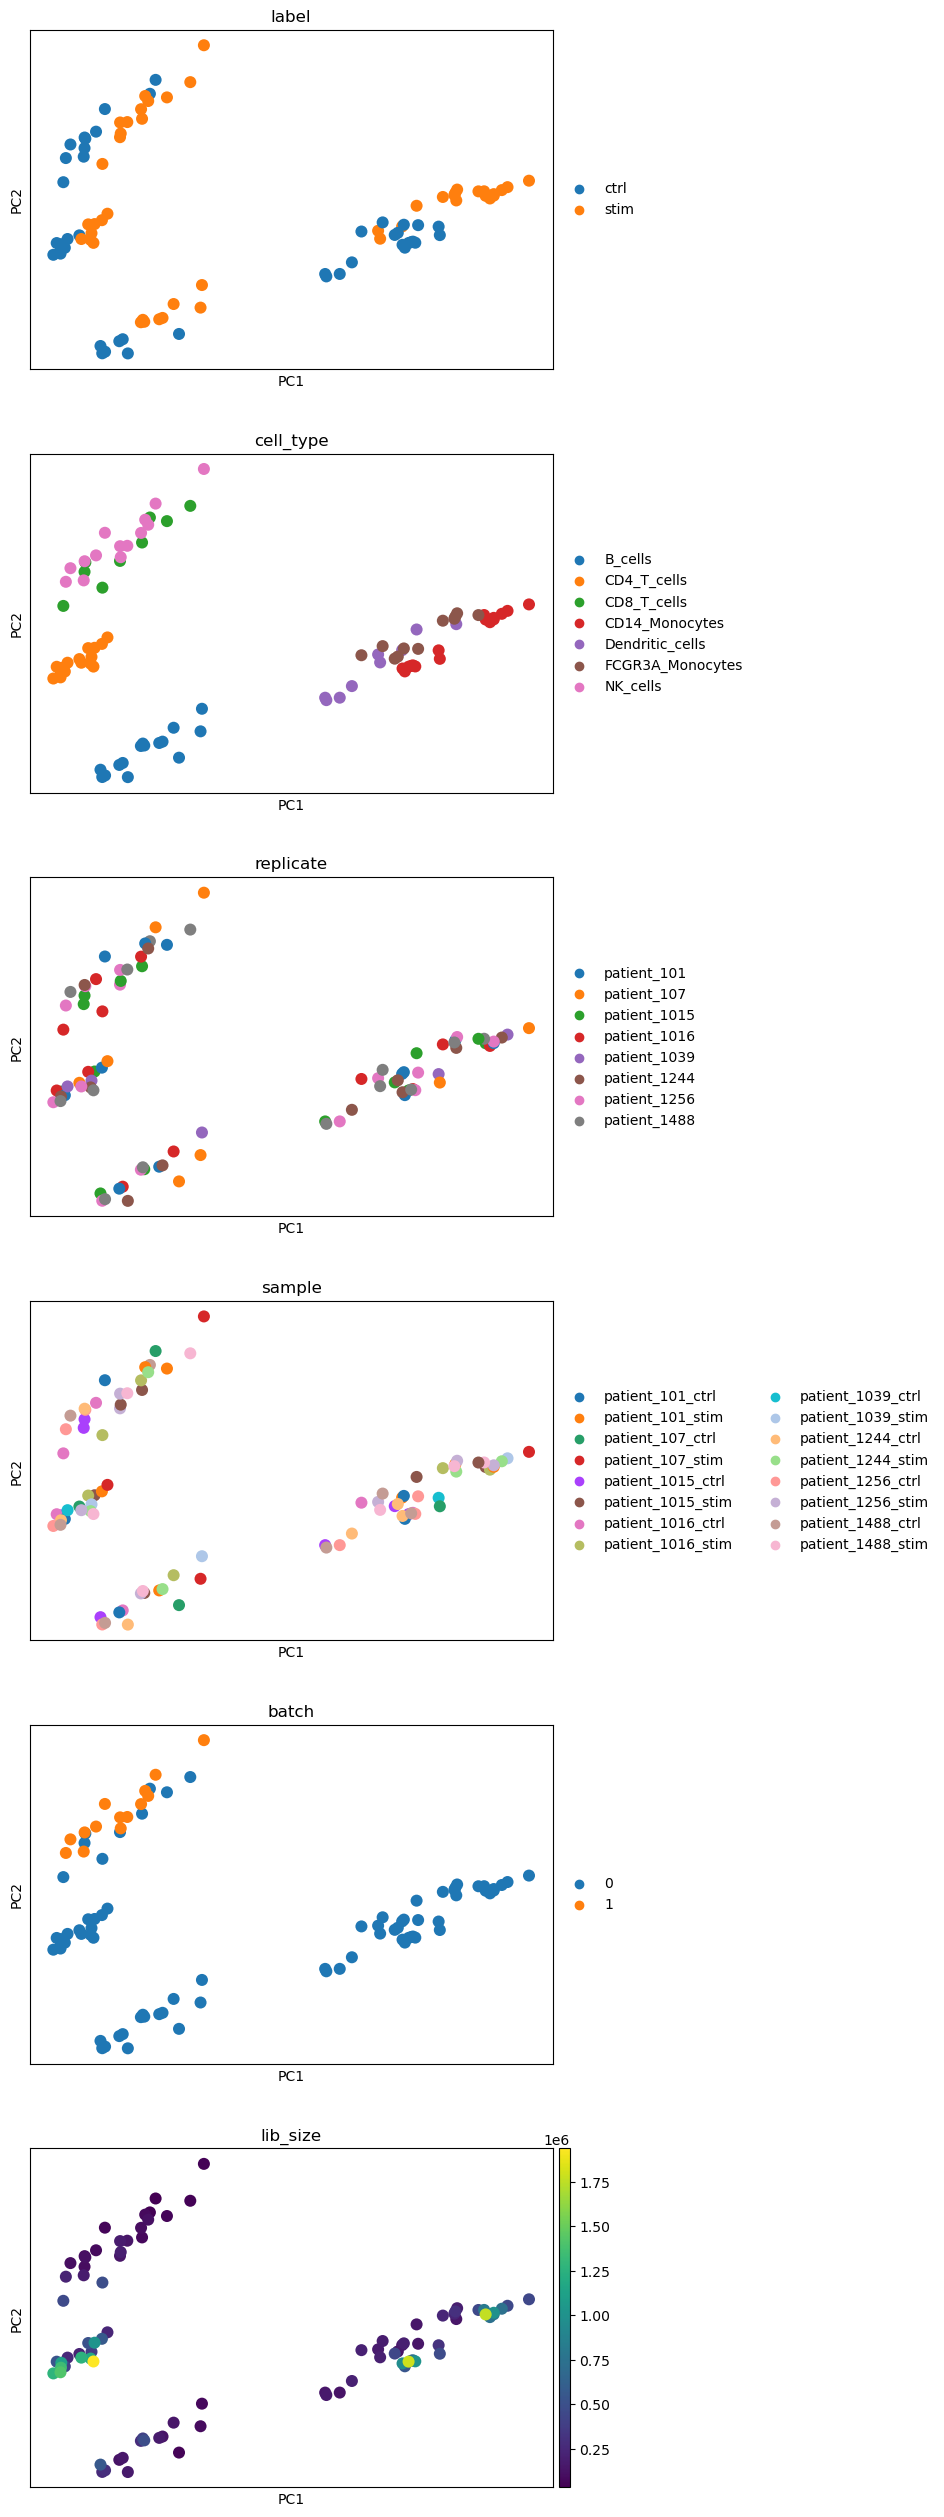

In [23]:
sc.pl.pca(adata_pb, color=adata_pb.obs, ncols=1, size=300)

In [24]:
adata_pb.X = adata_pb.layers['counts'].copy()

# 16.4.1. One group

In [25]:
adata_mono = adata_pb[adata_pb.obs["cell_type"] == "CD14_Monocytes"]
adata_mono

View of AnnData object with n_obs × n_vars = 16 × 15701
    obs: 'label', 'cell_type', 'replicate', 'sample', 'batch', 'lib_size'
    uns: 'log1p', 'pca', 'label_colors', 'cell_type_colors', 'replicate_colors', 'sample_colors', 'batch_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [26]:
adata_mono.obs_names = [
    name.split("_")[2] + "_" + name.split("_")[3] for name in adata_mono.obs_names
]

In [30]:
%%time
%%R -i adata_mono
outs <-fit_model(adata_mono)

NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'numpy.ndarray'>'

In [29]:
%reload_ext rpy2.ipython

In [31]:
%%R
fit <- outs$fit
y <- outs$y


Błąd w poleceniu 'withVisible({':nie znaleziono obiektu 'outs'


RInterpreterError: Failed to parse and evaluate line 'fit <- outs$fit\ny <- outs$y\n'.
R error message: "Błąd w poleceniu 'withVisible({':nie znaleziono obiektu 'outs'"

In [32]:
%%R
plotMDS(y, col=ifelse(y$samples$group == "stim", "red", "blue"))


Błąd w poleceniu 'plotMDS(y, col = ifelse(y$samples$group == "stim", "red", "blue"))':
  nie znaleziono obiektu 'y'


RInterpreterError: Failed to parse and evaluate line 'plotMDS(y, col=ifelse(y$samples$group == "stim", "red", "blue"))\n'.
R error message: 'Błąd w poleceniu \'plotMDS(y, col = ifelse(y$samples$group == "stim", "red", "blue"))\':\n  nie znaleziono obiektu \'y\''

In [33]:
%%R
plotBCV(y)


Błąd w poleceniu 'is(y, "DGEList")':nie znaleziono obiektu 'y'


RInterpreterError: Failed to parse and evaluate line 'plotBCV(y)\n'.
R error message: 'Błąd w poleceniu \'is(y, "DGEList")\':nie znaleziono obiektu \'y\''

In [34]:
%%R
colnames(y$design)


Błąd w poleceniu 'h(simpleError(msg, call))':
  błąd podczas obliczania argumentu 'x' przy wybieraniu metody dla funkcji 'colnames': nie znaleziono obiektu 'y'


RInterpreterError: Failed to parse and evaluate line 'colnames(y$design)\n'.
R error message: "Błąd w poleceniu 'h(simpleError(msg, call))':\n  błąd podczas obliczania argumentu 'x' przy wybieraniu metody dla funkcji 'colnames': nie znaleziono obiektu 'y'"

In [35]:
tt.shape

NameError: name 'tt' is not defined

In [36]:
tt[:5]

NameError: name 'tt' is not defined

In [37]:
%%R
tr <- glmTreat(fit, contrast=myContrast, lfc=1.5)
print(head(topTags(tr)))


Błąd w poleceniu 'glmTreat(fit, contrast = myContrast, lfc = 1.5)':
  nie znaleziono obiektu 'fit'


RInterpreterError: Failed to parse and evaluate line 'tr <- glmTreat(fit, contrast=myContrast, lfc=1.5)\nprint(head(topTags(tr)))\n'.
R error message: "Błąd w poleceniu 'glmTreat(fit, contrast = myContrast, lfc = 1.5)':\n  nie znaleziono obiektu 'fit'"

In [38]:
%%R
plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR<0.01)])


Błąd w poleceniu 'plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR < 0.01)])':
  nie znaleziono obiektu 'qlf'


RInterpreterError: Failed to parse and evaluate line 'plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR<0.01)])\n'.
R error message: "Błąd w poleceniu 'plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR < 0.01)])':\n  nie znaleziono obiektu 'qlf'"

# 16.4.2. Multiple groups

In [39]:
%%time
%%R -i adata_pb
outs <-fit_model(adata_pb)

NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'numpy.ndarray'>'

In [40]:
%%R
fit <- outs$fit
y <- outs$y


Błąd w poleceniu 'withVisible({':nie znaleziono obiektu 'outs'


RInterpreterError: Failed to parse and evaluate line 'fit <- outs$fit\ny <- outs$y\n'.
R error message: "Błąd w poleceniu 'withVisible({':nie znaleziono obiektu 'outs'"

In [41]:
%%R -i adata_pb -o de_per_cell_type
de_per_cell_type <- list()
for (cell_type in unique(colData(adata_pb)$cell_type)) {
    print(cell_type)
    # create contrast for this cell type
    myContrast <- makeContrasts(paste0("groupstim.", cell_type, "-groupctrl.", cell_type), levels = y$design)
    # perform QLF test
    qlf <- glmQLFTest(fit, contrast=myContrast)
    # get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
    tt <- topTags(qlf, n = Inf)
    # save in the list with the results for all the cell types
    de_per_cell_type[[cell_type]] <- tt$table
}

NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'numpy.ndarray'>'

In [42]:
# get cell types that we ran the analysis for
cell_types = de_per_cell_type.keys()
# add the table to .uns for each cell type
for cell_type in cell_types:
    df = de_per_cell_type[cell_type]
    df["gene_symbol"] = df.index
    df["cell_type"] = cell_type
    sc_toolbox.tools.de_res_to_anndata(
        adata,
        df,
        groupby="cell_type",
        score_col="logCPM",
        pval_col="PValue",
        pval_adj_col="FDR",
        lfc_col="logFC",
        key_added="edgeR_" + cell_type,
    )
    df.to_csv(f"de_edgeR_{cell_type}.csv")

NameError: name 'de_per_cell_type' is not defined

In [43]:
sc.get.rank_genes_groups_df(adata, group="CD14_Monocytes", key="edgeR_CD14_Monocytes")[
    :5
]

KeyError: 'edgeR_CD14_Monocytes'

# 16.5. Single-cell specific

In [44]:
adata.X = adata.layers["counts"].copy()

In [45]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

In [46]:
def prep_anndata(adata_):
    def fix_dtypes(adata_):
        df = pd.DataFrame(adata_.X.A, index=adata_.obs_names, columns=adata_.var_names)
        df = df.join(adata_.obs)
        return sc.AnnData(df[adata_.var_names], obs=df.drop(columns=adata_.var_names))

    adata_ = fix_dtypes(adata_)
    sc.pp.filter_genes(adata_, min_cells=3)
    return adata_

# 16.5.1. One group

In [47]:
adata_mono = adata[adata.obs["cell_type"] == "CD14_Monocytes"].copy()
adata_mono

AnnData object with n_obs × n_vars = 5696 × 15701
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_genes', 'sample'
    var: 'name', 'n_cells'
    uns: 'log1p'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [48]:
sc.pp.filter_genes(adata_mono, min_cells=3)
adata_mono

AnnData object with n_obs × n_vars = 5696 × 12268
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_genes', 'sample'
    var: 'name', 'n_cells'
    uns: 'log1p'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [49]:
adata_mono = prep_anndata(adata_mono)
adata_mono

AnnData object with n_obs × n_vars = 5696 × 12268
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_genes', 'sample'
    var: 'n_cells'

In [50]:
adata_mono.obs["cell_type"] = [
    ct.replace(" ", "_") for ct in adata_mono.obs["cell_type"]
]
adata_mono.obs["cell_type"] = [
    ct.replace("+", "") for ct in adata_mono.obs["cell_type"]
]

In [51]:
%%R
find_de_MAST_RE <- function(adata_){
    # create a MAST object
    sca <- SceToSingleCellAssay(adata_, class = "SingleCellAssay")
    print("Dimensions before subsetting:")
    print(dim(sca))
    print("")
    # keep genes that are expressed in more than 10% of all cells
    sca <- sca[freq(sca)>0.1,]
    print("Dimensions after subsetting:")
    print(dim(sca))
    print("")
    # add a column to the data which contains scaled number of genes that are expressed in each cell
    cdr2 <- colSums(assay(sca)>0)
    colData(sca)$ngeneson <- scale(cdr2)
    # store the columns that we are interested in as factors
    label <- factor(colData(sca)$label)
    # set the reference level
    label <- relevel(label,"ctrl")
    colData(sca)$label <- label
    celltype <- factor(colData(sca)$cell_type)
    colData(sca)$celltype <- celltype
    # same for donors (which we need to model random effects)
    replicate <- factor(colData(sca)$replicate)
    colData(sca)$replicate <- replicate
    # create a group per condition-celltype combination
    colData(sca)$group <- paste0(colData(adata_)$label, ".", colData(adata_)$cell_type)
    colData(sca)$group <- factor(colData(sca)$group)
    # define and fit the model
    zlmCond <- zlm(formula = ~ngeneson + group + (1 | replicate), 
                   sca=sca, 
                   method='glmer', 
                   ebayes=F, 
                   strictConvergence=F,
                   fitArgsD=list(nAGQ = 0)) # to speed up calculations
    
    # perform likelihood-ratio test for the condition that we are interested in    
    summaryCond <- summary(zlmCond, doLRT='groupstim.CD14_Monocytes')
    # get the table with log-fold changes and p-values
    summaryDt <- summaryCond$datatable
    result <- merge(summaryDt[contrast=='groupstim.CD14_Monocytes' & component=='H',.(primerid, `Pr(>Chisq)`)], # p-values
                     summaryDt[contrast=='groupstim.CD14_Monocytes' & component=='logFC', .(primerid, coef)],
                     by='primerid') # logFC coefficients
    # MAST uses natural logarithm so we convert the coefficients to log2 base to be comparable to edgeR
    result[,coef:=result[,coef]/log(2)]
    # do multiple testing correction
    result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
    result = result[result$FDR<0.01,, drop=F]

    result <- stats::na.omit(as.data.frame(result))
    return(result)
}

In [52]:
%%time
%%R -i adata_mono -o res
res <-find_de_MAST_RE(adata_mono)

ValueError: Not an rpy2 R object and unable to map it to one: AnnData object with n_obs × n_vars = 5696 × 12268
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_genes', 'sample'
    var: 'n_cells'

In [53]:
res[:5]

NameError: name 'res' is not defined

In [54]:
res["gene_symbol"] = res["primerid"]
res["cell_type"] = "CD14_Monocytes"
sc_toolbox.tools.de_res_to_anndata(
    adata,
    res,
    groupby="cell_type",
    score_col="coef",
    pval_col="Pr(>Chisq)",
    pval_adj_col="FDR",
    lfc_col="coef",
    key_added="MAST_CD14_Monocytes",
)

NameError: name 'res' is not defined

# 16.6. Visualization

In [55]:
adata.X = adata.layers["counts"].copy()
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

In [56]:
FDR = 0.01
LOG_FOLD_CHANGE = 1.5


def plot_heatmap(adata, group_key, group_name="cell_type", groupby="label"):
    cell_type = "_".join(group_key.split("_")[1:])
    res = sc.get.rank_genes_groups_df(adata, group=cell_type, key=group_key)
    res.index = res["names"].values
    res = res[
        (res["pvals_adj"] < FDR) & (abs(res["logfoldchanges"]) > LOG_FOLD_CHANGE)
    ].sort_values(by=["logfoldchanges"])
    print(f"Plotting {len(res)} genes...")
    markers = list(res.index)
    sc.pl.heatmap(
        adata[adata.obs[group_name] == cell_type].copy(),
        markers,
        groupby=groupby,
        swap_axes=True,
    )

In [57]:
plot_heatmap(adata, "edgeR_CD14_Monocytes")

KeyError: 'edgeR_CD14_Monocytes'

In [58]:
plot_heatmap(adata, "MAST_CD14_Monocytes")

KeyError: 'MAST_CD14_Monocytes'

In [59]:
FDR = 0.01
LOG_FOLD_CHANGE = 1.5


def volcano_plot(adata, group_key, group_name="cell_type", groupby="label", title=None):
    cell_type = "_".join(group_key.split("_")[1:])
    result = sc.get.rank_genes_groups_df(adata, group=cell_type, key=group_key).copy()
    result["-logQ"] = -np.log(result["pvals"].astype("float"))
    lowqval_de = result.loc[abs(result["logfoldchanges"]) > LOG_FOLD_CHANGE]
    other_de = result.loc[abs(result["logfoldchanges"]) <= LOG_FOLD_CHANGE]

    fig, ax = plt.subplots()
    sns.regplot(
        x=other_de["logfoldchanges"],
        y=other_de["-logQ"],
        fit_reg=False,
        scatter_kws={"s": 6},
    )
    sns.regplot(
        x=lowqval_de["logfoldchanges"],
        y=lowqval_de["-logQ"],
        fit_reg=False,
        scatter_kws={"s": 6},
    )
    ax.set_xlabel("log2 FC")
    ax.set_ylabel("-log Q-value")

    if title is None:
        title = group_key.replace("_", " ")
    plt.title(title)
    plt.show()

In [60]:
volcano_plot(adata, "MAST_CD14_Monocytes")

KeyError: 'MAST_CD14_Monocytes'

In [61]:
volcano_plot(adata, "edgeR_CD14_Monocytes")

KeyError: 'edgeR_CD14_Monocytes'